<a href="https://colab.research.google.com/github/Dhanush-adk/intro_to_dl/blob/main/Assignment_3/Assignment_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.7 MB/s eta 0:00:00
time: 351 µs (started: 2024-03-08 22:45:12 +00:00)


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from tqdm.notebook import tqdm
import seaborn as sns
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)


time: 6.7 s (started: 2024-03-08 22:45:12 +00:00)


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

time: 58.5 ms (started: 2024-03-08 22:45:19 +00:00)


In [54]:
class CharLstm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLstm, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.LSTM = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.LSTM(embedded)
        output = self.fc(output[:, -1, :])
        return output

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])
        return output
def predict_next_char(model, char_to_ix, ix_to_char, initial_str, max_length):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

time: 1.74 ms (started: 2024-03-08 23:41:14 +00:00)


In [98]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests

# Step 1: Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text  # This is the entire text data

# Step 2: Prepare the dataset
sequence_length = 20
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Step 3: Create a dataset class
class CharDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index], self.targets[index]

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


time: 4.27 s (started: 2024-03-09 00:28:46 +00:00)


In [21]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=20):
    model.to(device)

    train_loss_list, val_loss_list, val_accuracy_list = [], [], []

    # Training loop
    epochs = n_epochs
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(train_loader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_list.append(running_loss / len(test_loader))

        val_accuracy = 100 * (correct / total)
        val_accuracy_list.append(val_accuracy)
        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Calculate accuracy, precision, recall, and F1 for the final epoch (you may want to change this based on your requirements)

    return {
        'train_loss': train_loss_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'model': model
    }


time: 1.18 ms (started: 2024-03-08 23:00:49 +00:00)


# LSTM 20

In [28]:
hidden_size = 128
learning_rate = 0.005
epochs = 100

model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 5.42 ms (started: 2024-03-08 23:02:31 +00:00)


In [29]:
lstm_results = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.7492, Validation loss: 1.6364, Validation Accuracy: 50.71%
Epoch 2, Training loss: 1.5945, Validation loss: 1.5909, Validation Accuracy: 51.94%
Epoch 3, Training loss: 1.5610, Validation loss: 1.5750, Validation Accuracy: 52.12%
Epoch 4, Training loss: 1.5467, Validation loss: 1.5629, Validation Accuracy: 52.57%
Epoch 5, Training loss: 1.5432, Validation loss: 1.5638, Validation Accuracy: 52.91%
Epoch 6, Training loss: 1.5380, Validation loss: 1.5686, Validation Accuracy: 52.53%
Epoch 7, Training loss: 1.5398, Validation loss: 1.5682, Validation Accuracy: 52.50%
Epoch 8, Training loss: 1.5403, Validation loss: 1.5668, Validation Accuracy: 52.64%
Epoch 9, Training loss: 1.5419, Validation loss: 1.5867, Validation Accuracy: 52.17%
Epoch 10, Training loss: 1.5456, Validation loss: 1.5684, Validation Accuracy: 52.49%
time: 3min 49s (started: 2024-03-08 23:02:32 +00:00)


In [39]:
total_params = sum(p.numel() for p in lstm_results['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 148801
time: 709 µs (started: 2024-03-08 23:18:08 +00:00)


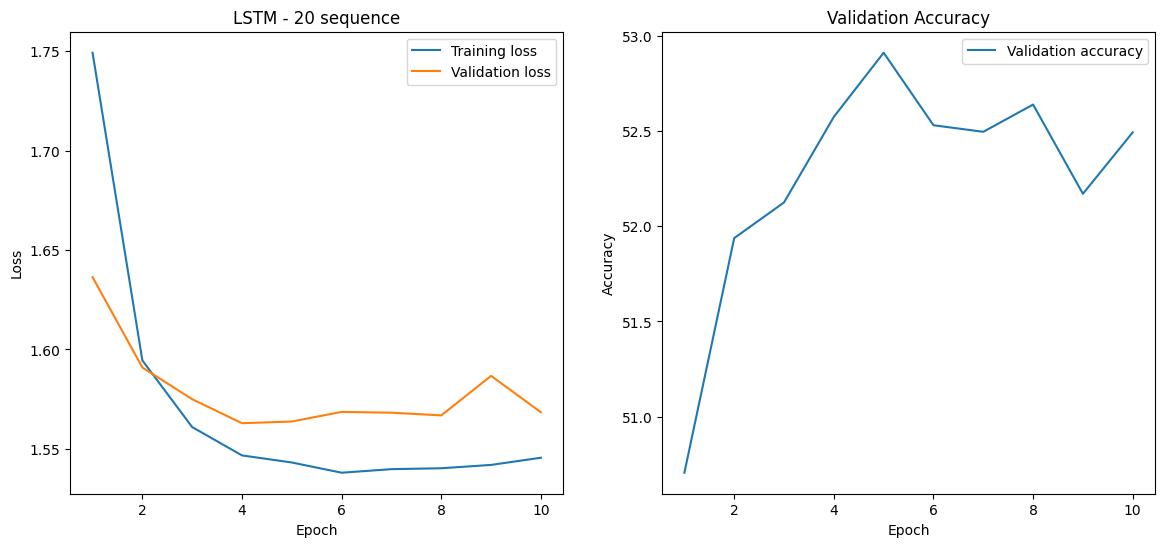

time: 328 ms (started: 2024-03-08 23:06:25 +00:00)


In [30]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, lstm_results['train_loss'], label='Training loss')
plt.plot(epochs_list, lstm_results['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 20 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, lstm_results['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [58]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(lstm_results['model'], char_to_int, int_to_char, test_str, 20)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 5.56 ms (started: 2024-03-08 23:43:01 +00:00)


#GRU 20

In [99]:
hidden_size = 128
learning_rate = 0.005
epochs = 100

model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 6.63 ms (started: 2024-03-09 00:28:59 +00:00)


In [100]:
gru_results_20 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.8477, Validation loss: 1.7703, Validation Accuracy: 47.78%
Epoch 2, Training loss: 1.7610, Validation loss: 1.7463, Validation Accuracy: 48.24%
Epoch 3, Training loss: 1.7689, Validation loss: 1.7678, Validation Accuracy: 48.17%
Epoch 4, Training loss: 1.7766, Validation loss: 1.7853, Validation Accuracy: 47.18%
Epoch 5, Training loss: 1.7818, Validation loss: 1.8052, Validation Accuracy: 46.44%
Epoch 6, Training loss: 1.7914, Validation loss: 1.8070, Validation Accuracy: 46.42%
Epoch 7, Training loss: 1.7946, Validation loss: 1.7782, Validation Accuracy: 47.85%
Epoch 8, Training loss: 1.7955, Validation loss: 1.8058, Validation Accuracy: 46.05%
Epoch 9, Training loss: 1.8138, Validation loss: 1.8130, Validation Accuracy: 47.13%
Epoch 10, Training loss: 1.8266, Validation loss: 1.8510, Validation Accuracy: 45.23%
time: 3min 51s (started: 2024-03-09 00:29:03 +00:00)


In [101]:
total_params = sum(p.numel() for p in gru_results_20['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 115777
time: 663 µs (started: 2024-03-09 00:32:54 +00:00)


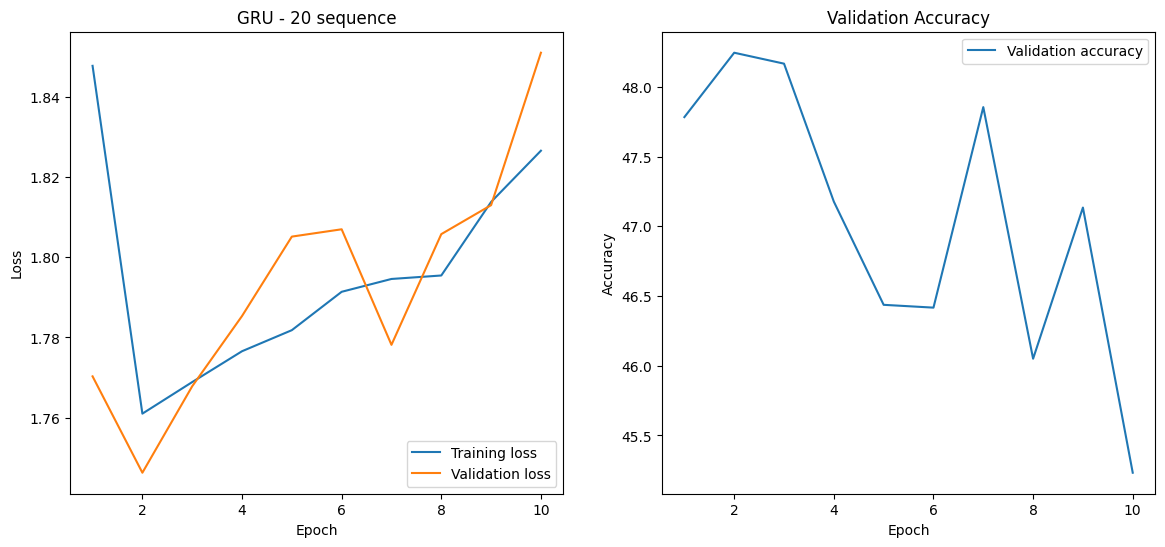

time: 338 ms (started: 2024-03-09 00:33:34 +00:00)


In [104]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gru_results_20['train_loss'], label='Training loss')
plt.plot(epochs_list, gru_results_20['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 20 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, gru_results_20['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [103]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(gru_results_20['model'], char_to_int, int_to_char, test_str, 20)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 2.55 ms (started: 2024-03-09 00:32:55 +00:00)


# LSTM 30

In [31]:
sequence_length = 30
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


time: 5.17 s (started: 2024-03-08 23:06:39 +00:00)


In [32]:
hidden_size = 128
learning_rate = 0.005
epochs = 10

model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 5.76 ms (started: 2024-03-08 23:06:44 +00:00)


In [33]:
lstm_results_30 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.7541, Validation loss: 1.6291, Validation Accuracy: 51.29%
Epoch 2, Training loss: 1.5920, Validation loss: 1.5685, Validation Accuracy: 52.58%
Epoch 3, Training loss: 1.5507, Validation loss: 1.5597, Validation Accuracy: 53.05%
Epoch 4, Training loss: 1.5363, Validation loss: 1.5369, Validation Accuracy: 53.39%
Epoch 5, Training loss: 1.5291, Validation loss: 1.5377, Validation Accuracy: 53.39%
Epoch 6, Training loss: 1.5266, Validation loss: 1.5359, Validation Accuracy: 53.67%
Epoch 7, Training loss: 1.5290, Validation loss: 1.5422, Validation Accuracy: 53.44%
Epoch 8, Training loss: 1.5278, Validation loss: 1.5431, Validation Accuracy: 53.49%
Epoch 9, Training loss: 1.5285, Validation loss: 1.5380, Validation Accuracy: 53.76%
Epoch 10, Training loss: 1.5314, Validation loss: 1.5545, Validation Accuracy: 53.30%
time: 4min 4s (started: 2024-03-08 23:06:57 +00:00)


In [38]:
total_params = sum(p.numel() for p in lstm_results_30['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 148801
time: 809 µs (started: 2024-03-08 23:18:00 +00:00)


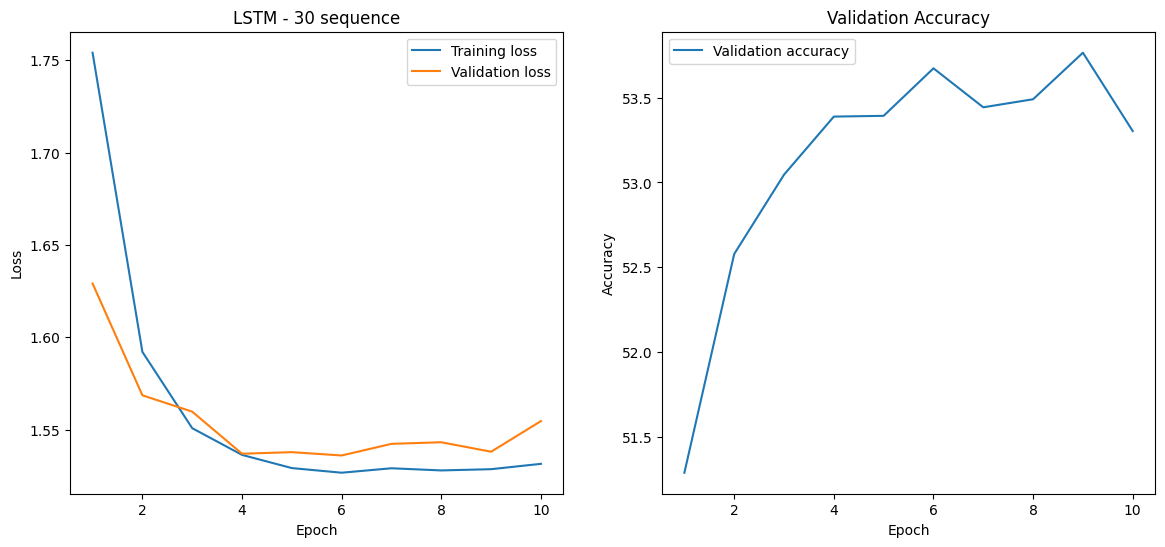

time: 353 ms (started: 2024-03-08 23:11:16 +00:00)


In [34]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, lstm_results_30['train_loss'], label='Training loss')
plt.plot(epochs_list, lstm_results_30['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 30 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, lstm_results_30['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [57]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(lstm_results_30['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 6.17 ms (started: 2024-03-08 23:42:33 +00:00)


#GRU 30

In [35]:
hidden_size = 128
learning_rate = 0.005
epochs = 10

model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 6.96 ms (started: 2024-03-08 23:13:35 +00:00)


In [36]:
gru_results_30 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.8359, Validation loss: 1.7728, Validation Accuracy: 47.93%
Epoch 2, Training loss: 1.7531, Validation loss: 1.7659, Validation Accuracy: 48.18%
Epoch 3, Training loss: 1.7546, Validation loss: 1.7600, Validation Accuracy: 48.58%
Epoch 4, Training loss: 1.7683, Validation loss: 1.7505, Validation Accuracy: 48.27%
Epoch 5, Training loss: 1.7794, Validation loss: 1.7763, Validation Accuracy: 47.66%
Epoch 6, Training loss: 1.7808, Validation loss: 1.7724, Validation Accuracy: 47.96%
Epoch 7, Training loss: 1.7876, Validation loss: 1.7841, Validation Accuracy: 47.68%
Epoch 8, Training loss: 1.7997, Validation loss: 1.8074, Validation Accuracy: 46.54%
Epoch 9, Training loss: 1.8018, Validation loss: 1.8159, Validation Accuracy: 46.94%
Epoch 10, Training loss: 1.8060, Validation loss: 1.8321, Validation Accuracy: 46.12%
time: 4min 1s (started: 2024-03-08 23:13:37 +00:00)


In [37]:
total_params = sum(p.numel() for p in gru_results_30['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 115777
time: 889 µs (started: 2024-03-08 23:17:44 +00:00)


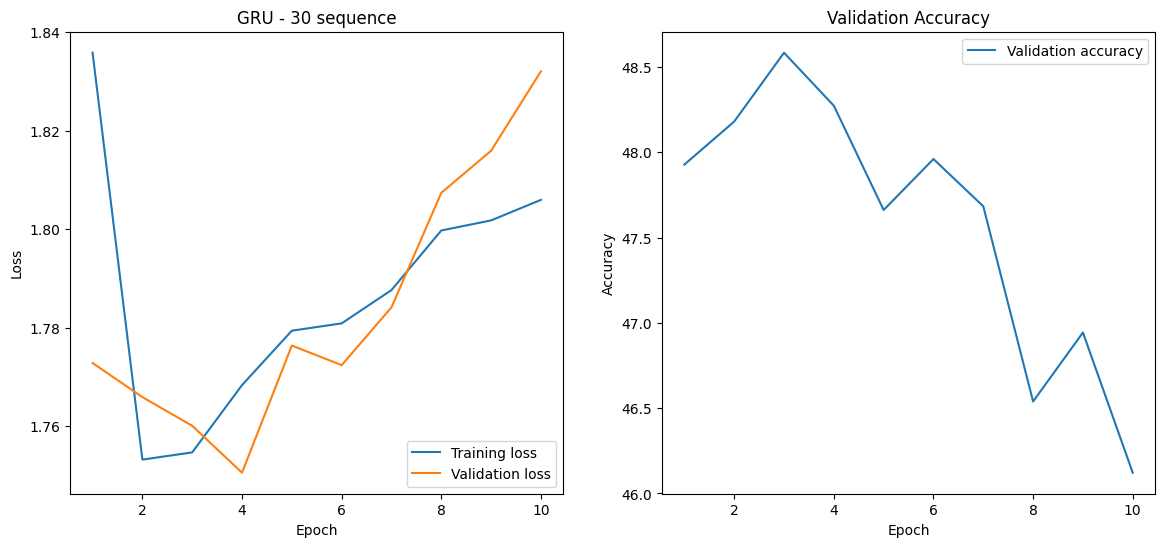

time: 335 ms (started: 2024-03-08 23:24:55 +00:00)


In [47]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gru_results_30['train_loss'], label='Training loss')
plt.plot(epochs_list, gru_results_30['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 30 sequence')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, gru_results_30['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [53]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(gru_results_30['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 4.52 ms (started: 2024-03-08 23:40:56 +00:00)


time: 1.17 s (started: 2024-03-08 23:40:44 +00:00)


#Problem 3_2_2

In [60]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 10.2 ms (started: 2024-03-08 23:44:26 +00:00)


In [61]:
lstm_results__hidden_20 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.7076, Validation loss: 1.5380, Validation Accuracy: 53.24%
Epoch 2, Training loss: 1.4835, Validation loss: 1.4659, Validation Accuracy: 55.23%
Epoch 3, Training loss: 1.4225, Validation loss: 1.4307, Validation Accuracy: 55.99%
Epoch 4, Training loss: 1.3864, Validation loss: 1.4043, Validation Accuracy: 56.78%
Epoch 5, Training loss: 1.3606, Validation loss: 1.3957, Validation Accuracy: 57.11%
Epoch 6, Training loss: 1.3408, Validation loss: 1.3874, Validation Accuracy: 57.32%
Epoch 7, Training loss: 1.3262, Validation loss: 1.3773, Validation Accuracy: 57.52%
Epoch 8, Training loss: 1.3134, Validation loss: 1.3734, Validation Accuracy: 57.53%
Epoch 9, Training loss: 1.3022, Validation loss: 1.3689, Validation Accuracy: 57.77%
Epoch 10, Training loss: 1.2932, Validation loss: 1.3636, Validation Accuracy: 58.09%
time: 4min 27s (started: 2024-03-08 23:44:51 +00:00)


In [62]:
total_params = sum(p.numel() for p in lstm_results__hidden_20['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 559681
time: 847 µs (started: 2024-03-08 23:49:21 +00:00)


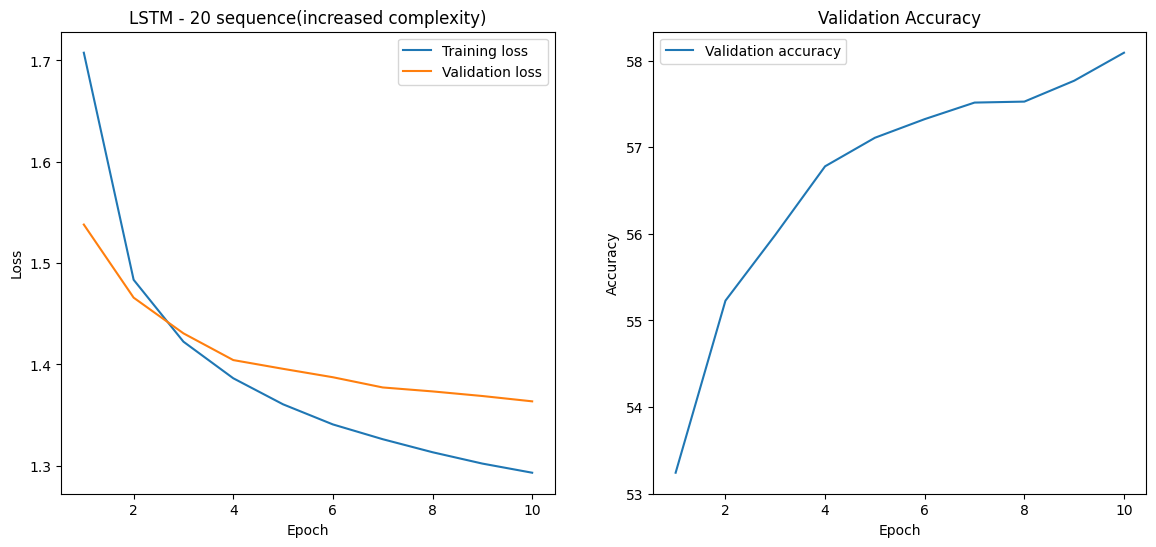

time: 340 ms (started: 2024-03-08 23:57:56 +00:00)


In [71]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, lstm_results__hidden_20['train_loss'], label='Training loss')
plt.plot(epochs_list, lstm_results__hidden_20['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 20 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, lstm_results__hidden_20['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [64]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(lstm_results__hidden_20['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 25.3 ms (started: 2024-03-08 23:49:45 +00:00)


In [65]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 8.49 ms (started: 2024-03-08 23:50:18 +00:00)


In [66]:
gru_results__hidden_20 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.6885, Validation loss: 1.5472, Validation Accuracy: 53.32%
Epoch 2, Training loss: 1.4954, Validation loss: 1.4857, Validation Accuracy: 54.88%
Epoch 3, Training loss: 1.4489, Validation loss: 1.4645, Validation Accuracy: 55.12%
Epoch 4, Training loss: 1.4239, Validation loss: 1.4462, Validation Accuracy: 55.77%
Epoch 5, Training loss: 1.4081, Validation loss: 1.4473, Validation Accuracy: 55.71%
Epoch 6, Training loss: 1.3966, Validation loss: 1.4351, Validation Accuracy: 56.06%
Epoch 7, Training loss: 1.3885, Validation loss: 1.4288, Validation Accuracy: 56.14%
Epoch 8, Training loss: 1.3832, Validation loss: 1.4257, Validation Accuracy: 56.46%
Epoch 9, Training loss: 1.3791, Validation loss: 1.4244, Validation Accuracy: 56.52%
Epoch 10, Training loss: 1.3775, Validation loss: 1.4256, Validation Accuracy: 56.36%
time: 4min 24s (started: 2024-03-08 23:50:44 +00:00)


In [67]:
total_params = sum(p.numel() for p in gru_results__hidden_20['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 428097
time: 911 µs (started: 2024-03-08 23:55:24 +00:00)


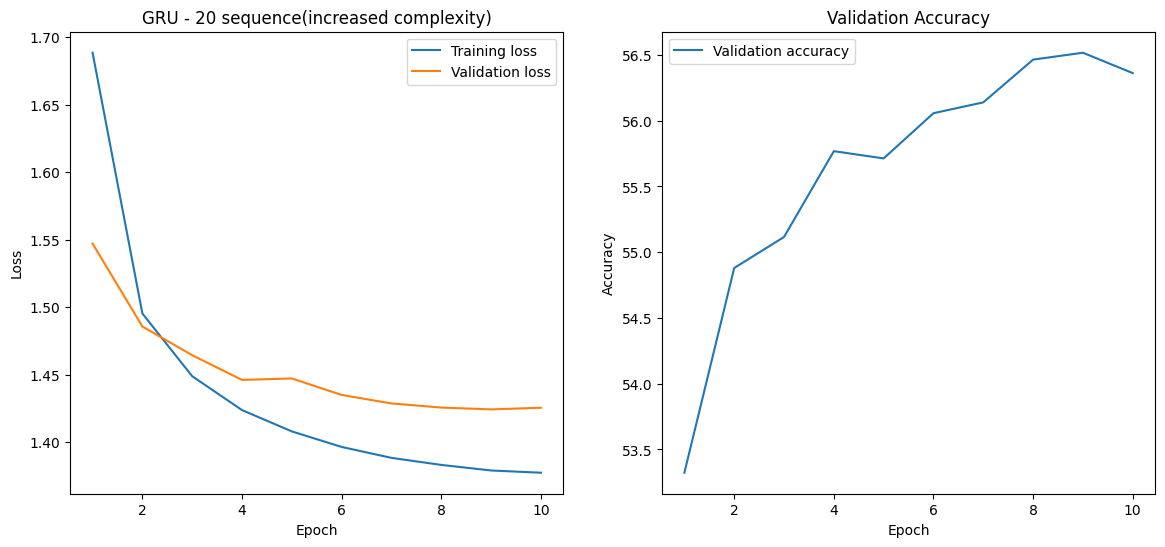

time: 357 ms (started: 2024-03-08 23:57:24 +00:00)


In [70]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gru_results__hidden_20['train_loss'], label='Training loss')
plt.plot(epochs_list, gru_results__hidden_20['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 20 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, gru_results__hidden_20['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [76]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(gru_results__hidden_20['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 6.48 ms (started: 2024-03-09 00:05:30 +00:00)


In [72]:
sequence_length = 30
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

time: 5.59 s (started: 2024-03-08 23:58:38 +00:00)


In [73]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 9.84 ms (started: 2024-03-08 23:59:22 +00:00)


In [74]:
lstm_results__hidden_30 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.6963, Validation loss: 1.5311, Validation Accuracy: 53.81%
Epoch 2, Training loss: 1.4748, Validation loss: 1.4568, Validation Accuracy: 55.48%
Epoch 3, Training loss: 1.4150, Validation loss: 1.4196, Validation Accuracy: 56.56%
Epoch 4, Training loss: 1.3791, Validation loss: 1.4035, Validation Accuracy: 56.86%
Epoch 5, Training loss: 1.3548, Validation loss: 1.3877, Validation Accuracy: 57.46%
Epoch 6, Training loss: 1.3353, Validation loss: 1.3775, Validation Accuracy: 57.69%
Epoch 7, Training loss: 1.3195, Validation loss: 1.3701, Validation Accuracy: 57.87%
Epoch 8, Training loss: 1.3060, Validation loss: 1.3687, Validation Accuracy: 58.14%
Epoch 9, Training loss: 1.2955, Validation loss: 1.3594, Validation Accuracy: 58.19%
Epoch 10, Training loss: 1.2855, Validation loss: 1.3585, Validation Accuracy: 58.36%
time: 5min 2s (started: 2024-03-08 23:59:53 +00:00)


In [77]:
total_params = sum(p.numel() for p in lstm_results__hidden_30['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 559681
time: 1.41 ms (started: 2024-03-09 00:05:40 +00:00)


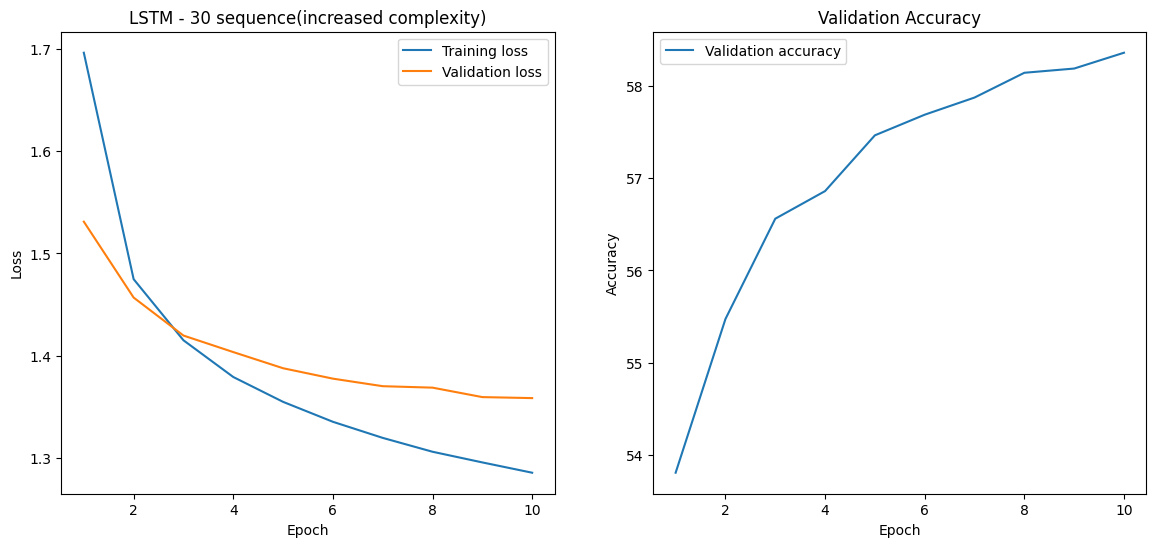

time: 348 ms (started: 2024-03-09 00:05:42 +00:00)


In [78]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, lstm_results__hidden_30['train_loss'], label='Training loss')
plt.plot(epochs_list, lstm_results__hidden_30['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 30 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, lstm_results__hidden_30['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [79]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(lstm_results__hidden_30['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 6.44 ms (started: 2024-03-09 00:06:12 +00:00)


In [80]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 8.92 ms (started: 2024-03-09 00:07:25 +00:00)


In [81]:
gru_results_hidden_30 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.6872, Validation loss: 1.5324, Validation Accuracy: 53.91%
Epoch 2, Training loss: 1.4934, Validation loss: 1.4850, Validation Accuracy: 55.16%
Epoch 3, Training loss: 1.4492, Validation loss: 1.4634, Validation Accuracy: 55.55%
Epoch 4, Training loss: 1.4230, Validation loss: 1.4457, Validation Accuracy: 56.06%
Epoch 5, Training loss: 1.4059, Validation loss: 1.4333, Validation Accuracy: 56.61%
Epoch 6, Training loss: 1.3940, Validation loss: 1.4264, Validation Accuracy: 56.46%
Epoch 7, Training loss: 1.3859, Validation loss: 1.4223, Validation Accuracy: 56.85%
Epoch 8, Training loss: 1.3780, Validation loss: 1.4201, Validation Accuracy: 56.81%
Epoch 9, Training loss: 1.3740, Validation loss: 1.4157, Validation Accuracy: 56.92%
Epoch 10, Training loss: 1.3712, Validation loss: 1.4117, Validation Accuracy: 57.09%
time: 4min 59s (started: 2024-03-09 00:08:00 +00:00)


In [83]:
total_params = sum(p.numel() for p in gru_results_hidden_30['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 428097
time: 930 µs (started: 2024-03-09 00:13:04 +00:00)


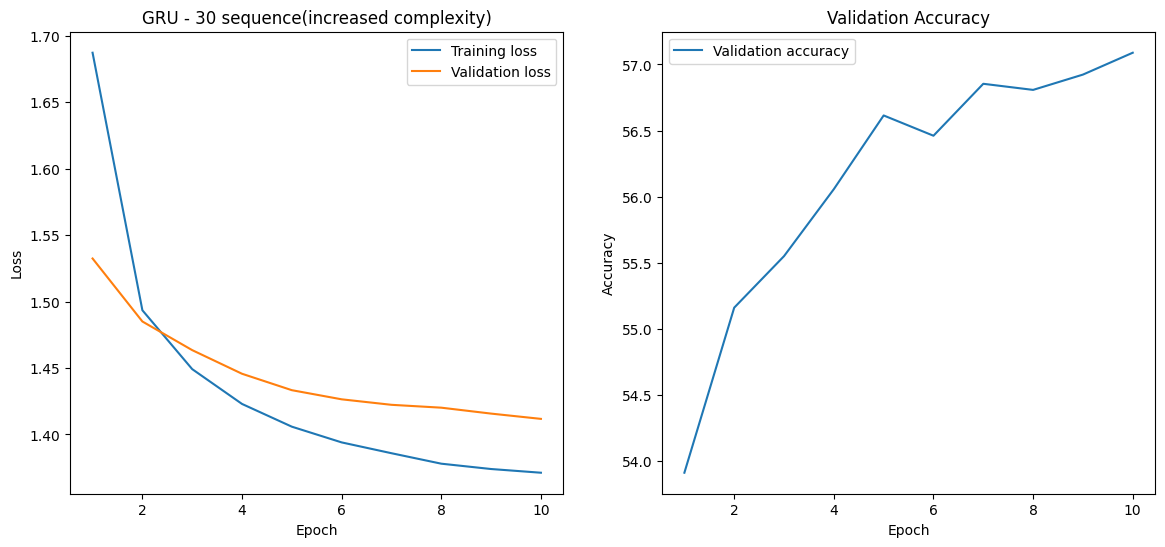

time: 349 ms (started: 2024-03-09 00:13:14 +00:00)


In [85]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gru_results_hidden_30['train_loss'], label='Training loss')
plt.plot(epochs_list, gru_results_hidden_30['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 30 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, gru_results_hidden_30['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [86]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(gru_results_hidden_30['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 6.69 ms (started: 2024-03-09 00:13:17 +00:00)


#Problem 3_2_3

In [87]:
sequence_length = 50
# Create a character mapping to integers
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# Encode the text into integers
encoded_text = [char_to_int[ch] for ch in text]

# Create sequences and targets
sequences = []
targets = []
for i in range(0, len(encoded_text) - sequence_length):
    seq = encoded_text[i:i+sequence_length]
    target = encoded_text[i+sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert lists to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

# Instantiate the dataset
dataset = CharDataset(sequences, targets)

# Step 4: Create data loaders
batch_size = 128
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)


time: 7.55 s (started: 2024-03-09 00:14:54 +00:00)


In [88]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharLstm(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 9.35 ms (started: 2024-03-09 00:15:08 +00:00)


In [89]:
lstm_results_hidden_50 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.7011, Validation loss: 1.5311, Validation Accuracy: 53.85%
Epoch 2, Training loss: 1.4693, Validation loss: 1.4560, Validation Accuracy: 55.54%
Epoch 3, Training loss: 1.4072, Validation loss: 1.4184, Validation Accuracy: 56.56%
Epoch 4, Training loss: 1.3704, Validation loss: 1.3940, Validation Accuracy: 57.13%
Epoch 5, Training loss: 1.3456, Validation loss: 1.3819, Validation Accuracy: 57.39%
Epoch 6, Training loss: 1.3259, Validation loss: 1.3739, Validation Accuracy: 57.73%
Epoch 7, Training loss: 1.3100, Validation loss: 1.3667, Validation Accuracy: 57.80%
Epoch 8, Training loss: 1.2964, Validation loss: 1.3582, Validation Accuracy: 58.28%
Epoch 9, Training loss: 1.2850, Validation loss: 1.3531, Validation Accuracy: 58.43%
Epoch 10, Training loss: 1.2755, Validation loss: 1.3511, Validation Accuracy: 58.36%
time: 5min 42s (started: 2024-03-09 00:15:33 +00:00)


In [90]:
total_params = sum(p.numel() for p in lstm_results_hidden_50['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 559681
time: 1.12 ms (started: 2024-03-09 00:21:23 +00:00)


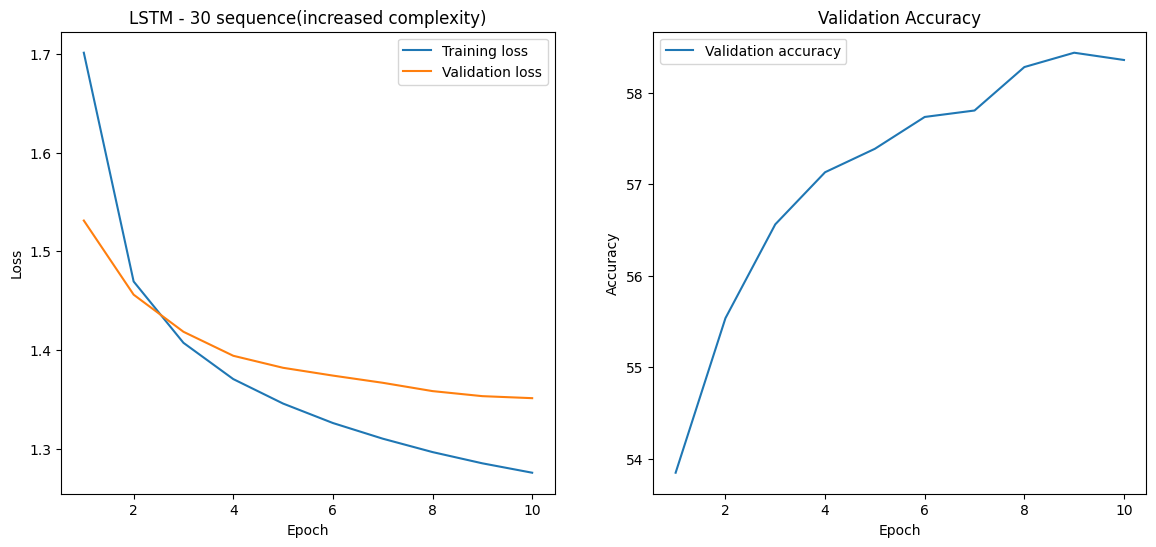

time: 358 ms (started: 2024-03-09 00:21:31 +00:00)


In [92]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, lstm_results_hidden_50['train_loss'], label='Training loss')
plt.plot(epochs_list, lstm_results_hidden_50['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM - 50 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, lstm_results_hidden_50['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

#GRU - 50

In [93]:
hidden_size = 256
learning_rate = 0.001
epochs = 10

model = CharGRU(len(chars), hidden_size, len(chars))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

time: 8.65 ms (started: 2024-03-09 00:21:56 +00:00)


In [94]:
gru_results_hidden_50 = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs=10)

Epoch 1, Training loss: 1.6819, Validation loss: 1.5397, Validation Accuracy: 53.61%
Epoch 2, Training loss: 1.4855, Validation loss: 1.4814, Validation Accuracy: 55.05%
Epoch 3, Training loss: 1.4371, Validation loss: 1.4483, Validation Accuracy: 55.80%
Epoch 4, Training loss: 1.4091, Validation loss: 1.4365, Validation Accuracy: 56.20%
Epoch 5, Training loss: 1.3921, Validation loss: 1.4220, Validation Accuracy: 56.75%
Epoch 6, Training loss: 1.3781, Validation loss: 1.4168, Validation Accuracy: 56.71%
Epoch 7, Training loss: 1.3703, Validation loss: 1.4122, Validation Accuracy: 56.82%
Epoch 8, Training loss: 1.3630, Validation loss: 1.4124, Validation Accuracy: 57.04%
Epoch 9, Training loss: 1.3588, Validation loss: 1.4115, Validation Accuracy: 56.96%
Epoch 10, Training loss: 1.3553, Validation loss: 1.4034, Validation Accuracy: 57.10%
time: 5min 40s (started: 2024-03-09 00:22:05 +00:00)


In [95]:
total_params = sum(p.numel() for p in gru_results_hidden_50['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 428097
time: 817 µs (started: 2024-03-09 00:27:48 +00:00)


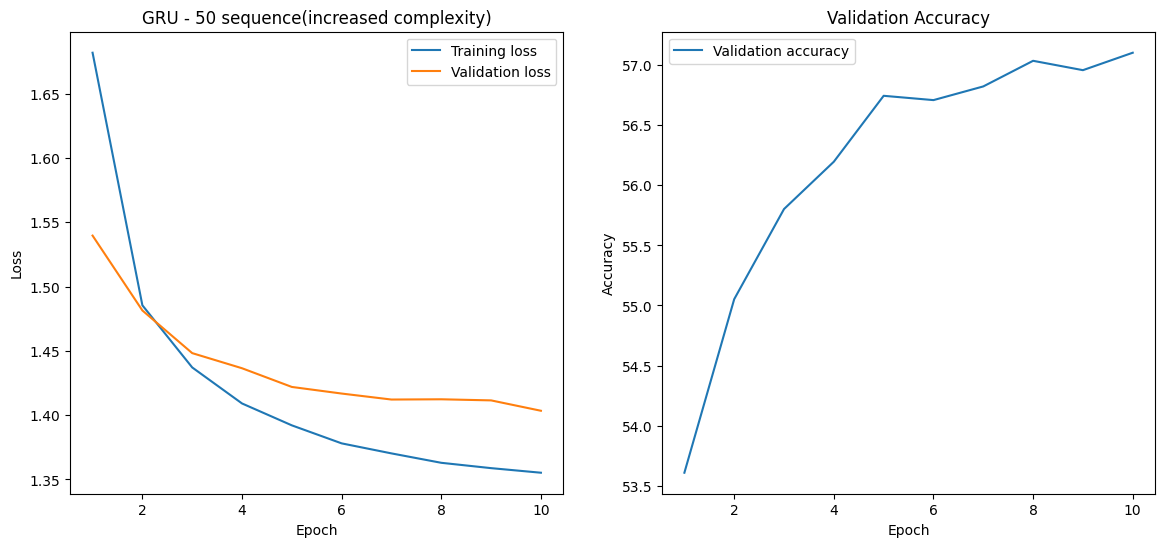

time: 408 ms (started: 2024-03-09 00:27:51 +00:00)


In [96]:
plt.figure(figsize=(14, 6))
epochs_list = [i for i in range(1, 10+1, 1)]

# Creating subplots
plt.subplot(1, 2, 1)
plt.plot(epochs_list, gru_results_hidden_50['train_loss'], label='Training loss')
plt.plot(epochs_list, gru_results_hidden_50['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU - 50 sequence(increased complexity)')

plt.subplot(1, 2, 2)
plt.plot(epochs_list, gru_results_hidden_50['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

# Show the combined plot
plt.show()

In [97]:
test_str = "This Course is an introduction to deep learnin"
predicted_char = predict_next_char(gru_results_hidden_50['model'], char_to_int, int_to_char, test_str, 30)
print(f"Predicted next character: '{predicted_char}'")

Predicted next character: 'g'
time: 6.03 ms (started: 2024-03-09 00:28:13 +00:00)
